In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
from lin_reg import best_line

### Table of Contents

1. Business Understanding
2. Data Understanding
3. Data Preparation
    - 3.i. TMDB data
    - 3.ii. The numbers data
        - 3.ii.a. Removing zeroes
        - 3.ii.b Keeping Only Post-2000 Data (Inclusive)
        - 3.ii.c. Creating an ROI column
        - 3.ii.d. Removing Budget Outliers
    - 3.iii. SQL IMDB Database
        - 3.iii.a Creating Directors and Writers DataFrames
    - 3.iv. Getting DataFrames for Runtime and Budget Regressions
    - 3.v. Creating DataFrames for 2-D and 3-D Movies
4. Data Analysis
    - 4.i Release Month Analysis
    - 4.ii 3-D vs. 2-D Analysis
    - 4.ii.a 2-Sample T-Tests on 2-D vs. 3-D
    - 4.iii. Experienced vs. Inexperienced Directors and Writers Analysis
        - Directors hypothesis test
        - Writers hypothesis test
    - 4.iv. Runtime and Budget Analysis
        - Budget Regressions and Visuals
        - Runtime Regressions and Visuals


# (1) Business Understanding 

Our firm is advising a company that plans to venture into the movie industry. We are tasked with finding trends and relationships that may guide their decisions regarding how to enter the industry. Such exploration may include recommendations on movie type, who to hire, when to make movies, how much to spend, etc., all in order to maximize profits. 

The data we will use is publicly available through [IMDB](https://www.imdb.com/), [Box Office Mojo](https://www.boxofficemojo.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/), [The Movie Database (TMDB)](https://www.themoviedb.org/), and [The Numbers](https://www.the-numbers.com/).

By the end of our analysis, we will provide five data-backed and statistically tested recommendations for our client's new movie studio.

# (2) Data Understanding

In [2]:
# Importing our datasets

tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz')
conn = sqlite3.connect('data/im.db')

# (3) Data Preparation

## (3.i) TMDB Data

This data comes from The Movie Database (TMDB), which can be accessed [here](https://www.themoviedb.org/?language=en-US).

We can first check out our `tmdb_movies` data using a `.info()` and `.head()`. We can see that we have 26,517 rows to start, with 9 columns of data and an index column. We have some basic information about the film -- notably the name and release date -- as well as some metrics relating to popularity: `popularity`, `vote_average`, `vote_count`. 

In [3]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


We'll then do some basic data cleaning. We're eventually going to merge with a few other dataframes using the name of the film, so we're going to preemptively change the `title` column to be named `primary_title`. We'll also drop those columns of data which are unnecessary for our analysis. As we would expect, we still have our 26,517 records.

In [4]:
# Rename the title column to primary_title to match the other dataframes
tmdb_movies.rename(columns={'title': 'primary_title'}, inplace=True)
# Drop the columns that are not needed
tmdb_movies.drop(columns=['genre_ids', 'original_language', 'original_title'], inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26517 non-null  int64  
 1   id             26517 non-null  int64  
 2   popularity     26517 non-null  float64
 3   release_date   26517 non-null  object 
 4   primary_title  26517 non-null  object 
 5   vote_average   26517 non-null  float64
 6   vote_count     26517 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


## (3.ii) The Numbers Data
Our next dataset comes from The Numbers, which can be found [here](https://www.the-numbers.com/movie/budgets/all). 

We'll once again start off with a `.info()` and `.head()` so that we can get a sense of what's contained in the data. Here, we get some of our financial information. Specifically, we can see the reported `production_budget` of the movie, along with its `domestic_gross` and `worldwide_gross`. From here, we'll be able to compute a rudimentary (if somewhat flawed) return on investment (ROI) figure. 

In [5]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [6]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We can also see that the `movie` column corresponds to the name of the film, so we will once again rename that column to `primary_title` so that we can perform merges later. Additionally, the financial columns are formatted as strings rather than integers. We will first strip the dollar signs and commas out of the string and then convert the columns to the integer datatype, so that we can more easily perform our analyses. We also will convert `release_date` to a `datetime` object, and from there extract both the month and year of release, and create the corresponding columns `release_month` and `release_year`.

In [7]:
# Rename the movie column to primary_title to match the other dataframes
tn_movie_budgets.rename(columns={'movie': 'primary_title'}, inplace=True)
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [8]:
# Convert the release_date column to a datetime object and create new columns for release_month and release_year
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_month'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.month_name()
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

In [9]:
# Create a function to allow us to convert the columns to integers
def convert_to_int(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '').astype(int)
    return df[column]

# Call the function for our three columns
convert_to_int(tn_movie_budgets, 'domestic_gross')
convert_to_int(tn_movie_budgets, 'worldwide_gross')
convert_to_int(tn_movie_budgets, 'production_budget')

# Check to make sure everything looks alright
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 361.5+ KB


In [10]:
# We'll also order our months chronologically, so when we plot them, the x
# Axis won't be in alphabetical order.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tn_movie_budgets['release_month'] = pd.Categorical(tn_movie_budgets['release_month'], categories=months, ordered=True)
tn_movie_budgets['release_month'].value_counts()

December     745
October      573
August       496
September    493
November     486
June         479
March        470
April        454
July         440
May          407
February     392
January      347
Name: release_month, dtype: int64

### (3.ii.a) Removing zeroes

Within this dataset, we have a number of films for which there is no reported budget data. Since one of our chief concerns is the financial success of a film, the lack of data on these fronts makes those records useless. 

We first check to make sure that removing the data for which we have no budget information does not throw out an excessive number of records. We go from 5,782 entries to 5,234, so it seems pretty safe to remove the zeroes.

In [11]:
tn_movie_budgets.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,December,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,May,2011
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,June,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,May,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,December,2017


In [12]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 322.4+ KB


In [13]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [14]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 194 to 5780
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 548 non-null    int64         
 1   release_date       548 non-null    datetime64[ns]
 2   primary_title      548 non-null    object        
 3   production_budget  548 non-null    int64         
 4   domestic_gross     548 non-null    int64         
 5   worldwide_gross    548 non-null    int64         
 6   release_month      548 non-null    category      
 7   release_year       548 non-null    int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 35.2+ KB


In [15]:
# Since we wouldn't lose too much data, we can drop the zeroes
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0]

In [16]:
tn_movie_budgets['domestic_gross'].isna().sum()

0

In [17]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [18]:
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].astype(int)

In [19]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 0 non-null      int64         
 1   release_date       0 non-null      datetime64[ns]
 2   primary_title      0 non-null      object        
 3   production_budget  0 non-null      int64         
 4   domestic_gross     0 non-null      int64         
 5   worldwide_gross    0 non-null      int64         
 6   release_month      0 non-null      category      
 7   release_year       0 non-null      int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 416.0+ bytes


One potentially problematic point is the spread of data for the `release_year`. Just from a preliminary look, we can see that there are a handful of films from the very early days of cinema. Since these will likely not have huge bearing on a start-up production company today, and since they constitute a very small proportion of our data, we can go ahead and filter them out. 

Below, you can see the distribution and count for our full dataset. We go from 5234 entries to 3865 entries.

In [20]:
tn_movie_budgets['release_year'].value_counts().sort_index()

1915      1
1916      1
1920      1
1925      2
1929      1
       ... 
2015    208
2016    192
2017    149
2018    137
2019     44
Name: release_year, Length: 92, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


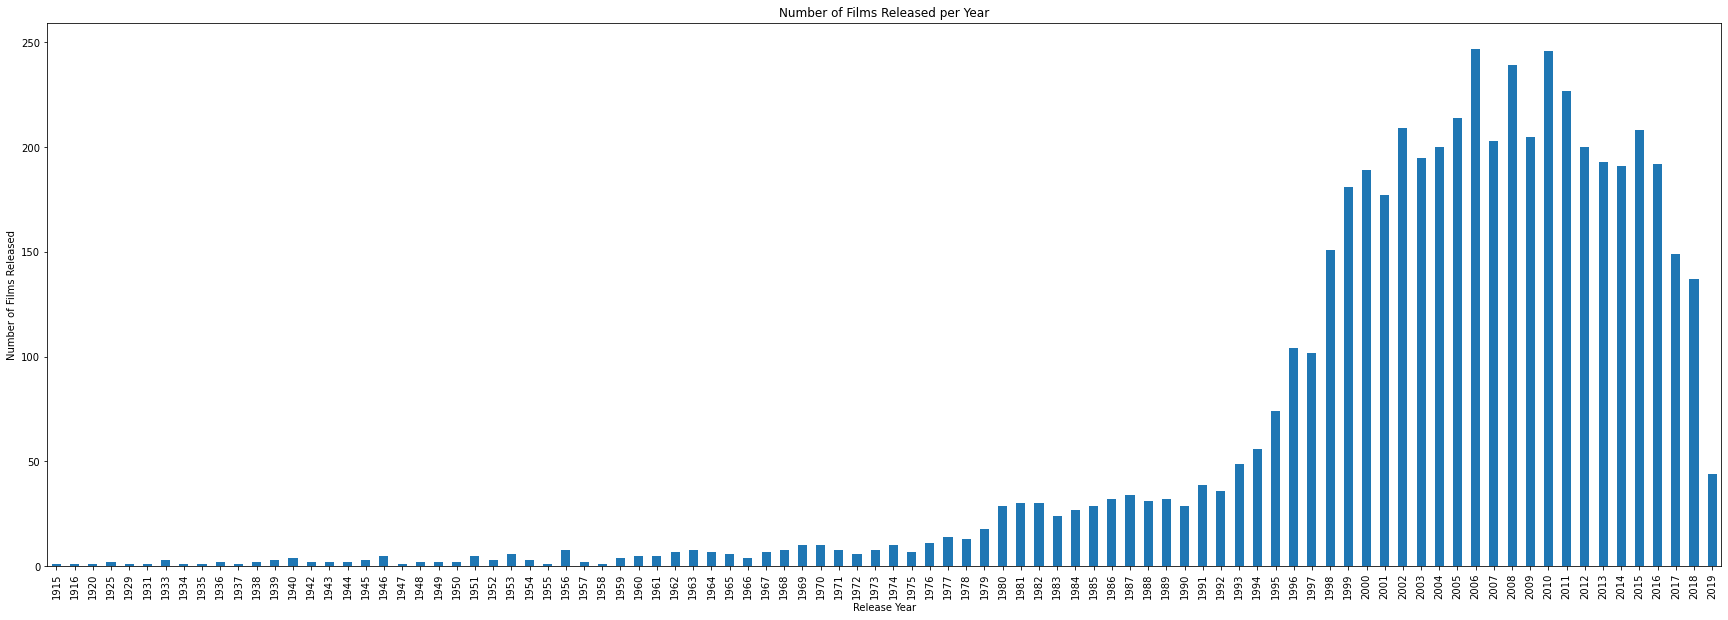

In [21]:
ax1 = plt.subplots(figsize = (30, 10))

ax1 = tn_movie_budgets['release_year'].value_counts().sort_index().plot.bar()
ax1.set_title('Number of Films Released per Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Films Released')

plt.style.use('ggplot')
tn_movie_budgets.info()


This graph justifies our decision to focus only on data from recent films. As the vast majority of films in this dataset are post-2000, we will subset to this period.

### (3.ii.b) Keeping Only Post-2000 Data (Inclusive)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 245.7+ KB


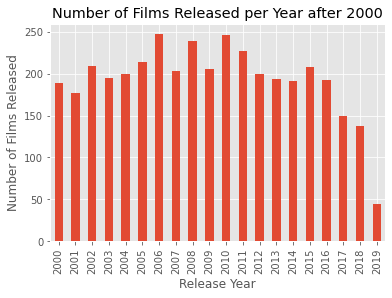

In [22]:
tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()

ax2 = tn_2000['release_year'].value_counts().sort_index().plot.bar()
ax2.set_title('Number of Films Released per Year after 2000')
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Number of Films Released')


plt.style.use('ggplot')
tn_2000.info()

In [23]:
# Saving the year filter in place
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 245.7+ KB


### (3.ii.c) Creating an ROI Column

In [24]:
tn_movie_budgets['domestic_ROI'] = ((tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

tn_movie_budgets['worldwide_ROI'] = ((tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

In [25]:
tn_movie_budgets.isna().sum()

id                   0
release_date         0
primary_title        0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_month        0
release_year         0
domestic_ROI         0
worldwide_ROI        0
dtype: int64

In [26]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
 8   domestic_ROI       3865 non-null   float64       
 9   worldwide_ROI      3865 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 306.1+ KB


In [27]:
# Since there are very few nulls relative to all the domestic_gross data points, we drop them here
tn_movie_budgets.dropna(subset = ['domestic_gross'], inplace=True)

In [28]:
tn_movie_budgets.isna().sum()

id                   0
release_date         0
primary_title        0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_month        0
release_year         0
domestic_ROI         0
worldwide_ROI        0
dtype: int64

### (3.ii.d) Removing Budget Outliers

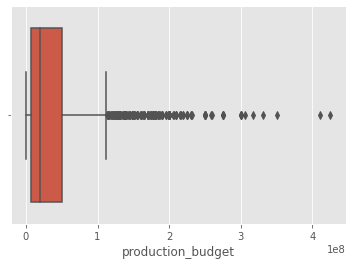

In [29]:
#Boxplot to visualize the outliers
sns.boxplot(x=tn_movie_budgets['production_budget'])
plt.show()

In [30]:
# Calculating the first and third quartiles for production budget
Q1 = tn_movie_budgets['production_budget'].quantile(0.25)
Q3 = tn_movie_budgets['production_budget'].quantile(0.75)

# Calculating the Interquartile Range
IQR = Q3 - Q1

# Getting the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing the rows with production budget outliers, saving as a separate df
tn_movie_budgets_no_outliers= tn_movie_budgets.loc[(tn_movie_budgets['production_budget'] >= lower_bound) & (tn_movie_budgets['production_budget'] <= upper_bound)]


## (3.iii) SQL IMDB Database

In [31]:
# Viewing the schema
pd.read_sql('SELECT name AS "Table Names" FROM sqlite_master WHERE type="table"', conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [32]:
# Making the movie_basics table into a DataFrame
imdb_movie_basics = pd.read_sql('SELECT * FROM movie_basics', conn)
imdb_movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [33]:
# Making the movie_akas table into a DataFrame
imdb_movie_akas = pd.read_sql('SELECT * FROM movie_akas', conn)
imdb_movie_akas.drop(columns=['is_original_title'], inplace=True)
imdb_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes
0,tt0369610,10,Джурасик свят,BG,bg,None,None
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None


In [34]:
#Renaming 'movie' column to 'primary_title' so I can join table with 'tn_movie_budgets' table
imdb_movie_akas = imdb_movie_akas.rename(columns={"title": "primary_title"})

In [35]:
imdb_movie_akas['attributes'].isna().sum()

316778

In [36]:
imdb_movie_akas = imdb_movie_akas.dropna(subset=['attributes'])

In [37]:
imdb_movie_akas['attributes'].isna().sum()

0

### (3.iii.a) Creating Directors and Writers DataFrames

A big part of what makes a good movie is not just the money that goes into it, but the people that we hire with that money. The "creators" include directors and writers. Our IMDB database contains over 100k distinct directors and over 120k distinct writers, as you can see from the two cells below.

In [38]:
# Exploring how many individual directors are in the IMDB directors table
imdb_directors = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM directors;
    """, conn)
imdb_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109253 entries, 0 to 109252
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  109253 non-null  object
dtypes: object(1)
memory usage: 853.7+ KB


In [39]:
# Exploring how many individual writers are in the IMDB writers table
imdb_writers = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM writers;
    """, conn)
imdb_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122576 entries, 0 to 122575
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  122576 non-null  object
dtypes: object(1)
memory usage: 957.8+ KB


We would like to advise our clients on the smartest hiring decisions. From this IMDB dataset, we are able to separate the "creators" of films based on their experience level. Here, we split creators into two groups each:

Experienced directors vs. inexperienced directors

Experienced writers vs. inexperienced writers

We have set the threshold for "experience" at 2 movies in order to keep the sample sizes comparable. In addition, it is a reasonable assumption to call a creator who has worked on fewer than 3 movies an inexperienced employee. 

In [40]:
# DataFrame for inexperienced directors
d_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() <=2) AS d_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,33586.000000,33586.000000,33586,33586
unique,NaN,NaN,33586,29190
top,NaN,NaN,nm7485387,"Milano 55,1. Cronaca di una settimana di passioni"
freq,NaN,NaN,1,45
mean,6.542941,716.307479,NaN,NaN
std,1.498878,7139.384418,NaN,NaN
min,1.000000,5.000000,NaN,NaN
25%,5.600000,10.000000,NaN,NaN
50%,6.700000,27.000000,NaN,NaN
75%,7.600000,118.000000,NaN,NaN


In [41]:
# DataFrame for experienced directors
d_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_n_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() >2) AS d_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,18745.000000,1.874500e+04,18745,18745
unique,NaN,NaN,18745,15096
top,NaN,NaN,nm0453965,World of Death
freq,NaN,NaN,1,83
mean,6.224791,4.648353e+03,NaN,NaN
std,1.408533,3.244858e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.800000e+01,NaN,NaN
50%,6.400000,7.000000e+01,NaN,NaN
75%,7.200000,4.020000e+02,NaN,NaN


In [42]:
# DataFrame for inexperienced writers
w_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_n_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() <=2) as w_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,58400.000000,5.840000e+04,58400,58400
unique,NaN,NaN,58400,38444
top,NaN,NaN,nm10506501,Mapa de recuerdos de Madrid
freq,NaN,NaN,1,27
mean,6.276384,3.485554e+03,NaN,NaN
std,1.450011,2.729246e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.500000e+01,NaN,NaN
50%,6.400000,5.500000e+01,NaN,NaN
75%,7.300000,3.200000e+02,NaN,NaN


In [43]:
# DataFrame for experienced writers

w_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() >2) as w_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,13653.000000,1.365300e+04,13653,13653
unique,NaN,NaN,13653,9108
top,NaN,NaN,nm1965378,World of Death
freq,NaN,NaN,1,46
mean,6.159408,8.204293e+03,NaN,NaN
std,1.412289,4.743662e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.300000,2.000000e+01,NaN,NaN
50%,6.300000,9.300000e+01,NaN,NaN
75%,7.100000,6.040000e+02,NaN,NaN


Now we have our four separate dataframes: experienced directors, inexperienced directors, experienced writers, and inexperienced writers. 

We want to test these categories against three dependent variables: popularity, domestic gross, and domestic ROI. In order to do this, we will merge tmdb_movies (a dataset containing popularity ratings) and tn_movie_budgets_no_outliers (a dataset containing production budget, gross, and ROI info) onto each of the four datasets.

In [44]:
# Merging the experienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_e = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_d_e = pd.merge(merged_d_e, tn_movie_budgets_no_outliers, on='primary_title')
merged_d_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,7.6,326657,nm0587955,Moneyball,2505,60308,15.393,2011-09-22,7.1,2255,15,2011-09-23,50000000,75605492,111300835,September,2011,51.210984,122.601670
1,4.4,69199,nm0455078,Sex and the City 2,137,37786,9.986,2010-05-27,5.9,809,16,2010-05-27,95000000,95347692,294680778,May,2010,0.365992,210.190293
2,5.6,44490,nm2552536,Don't Be Afraid of the Dark,214,46261,8.405,2010-11-06,5.5,550,43,2011-08-26,25000000,24046682,39126427,August,2011,-3.813272,56.505708
3,7.0,85839,nm2648685,Another Earth,2633,55420,10.030,2011-07-22,6.7,853,48,2011-07-22,175000,1321194,2102779,July,2011,654.968000,1101.588000
4,4.7,59914,nm0001774,Zoolander 2,17483,329833,12.997,2016-02-12,4.7,1374,64,2016-02-12,50000000,28848693,55348693,February,2016,-42.302614,10.697386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,6.2,760,nm0502412,Out of the Blue,10024,281697,0.600,2013-10-01,10.0,1,23,2007-10-19,4600000,728,731767,October,2007,-99.984174,-84.092022
688,7.7,310,nm0391473,Brothers,13497,397805,0.600,2014-01-01,7.3,3,41,2009-12-04,26000000,28544157,45043870,December,2009,9.785219,73.245654
689,7.7,310,nm0391473,Brothers,13497,397805,0.600,2014-01-01,7.3,3,8,2015-08-14,13000000,656688,17856688,August,2015,-94.948554,37.359138
690,7.7,310,nm0391473,Brothers,19396,382659,0.840,2016-04-04,2.0,1,41,2009-12-04,26000000,28544157,45043870,December,2009,9.785219,73.245654


In [45]:
# Merging the inexperienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_n_e = pd.merge(d_n_e, tmdb_movies, on='primary_title')
merged_d_n_e = pd.merge(merged_d_n_e, tn_movie_budgets_no_outliers, on='primary_title')
merged_d_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,7.0,1613,nm1464150,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
1,6.5,13,nm4418339,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
2,7.1,129443,nm0002339,Remember Me,92,23169,11.453,2010-03-12,7.1,2079,51,2010-03-12,16000000,19068240,56506120,March,2010,19.176500,253.163250
3,5.2,72,nm3566419,Remember Me,92,23169,11.453,2010-03-12,7.1,2079,51,2010-03-12,16000000,19068240,56506120,March,2010,19.176500,253.163250
4,5.6,66303,nm0867127,House at the End of the Street,5357,82505,8.720,2012-09-21,5.8,1033,73,2012-09-21,6900000,31611916,44103982,September,2012,358.143710,539.188145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,5.7,37,nm0928316,Sisters,14294,266294,10.993,2015-12-18,5.9,922,57,2015-12-18,30000000,87044645,106030660,December,2015,190.148817,253.435533
616,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014,-99.760364,-99.760364
617,7.7,1165,nm4717106,Phantom,8199,152259,7.211,2013-03-01,6.0,151,43,2013-03-01,18000000,1034589,1199510,March,2013,-94.252283,-93.336056
618,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014,108.838957,108.838957


In [46]:
# Merging the experienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_e = pd.merge(w_e, tmdb_movies, on='primary_title')
merged_w_e = pd.merge(merged_w_e, tn_movie_budgets_no_outliers, on='primary_title')
merged_w_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,7.0,85839,nm2648685,Another Earth,2633,55420,10.030,2011-07-22,6.7,853,48,2011-07-22,175000,1321194,2102779,July,2011,654.968000,1101.588000
1,6.4,6466,nm0119989,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
2,6.4,6466,nm1164861,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
3,6.4,6466,nm1823216,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
4,6.4,6466,nm1823227,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014,-99.760364,-99.760364
620,6.2,760,nm0502412,Out of the Blue,10024,281697,0.600,2013-10-01,10.0,1,23,2007-10-19,4600000,728,731767,October,2007,-99.984174,-84.092022
621,6.1,36062,nm0878756,A Hologram for the King,17537,270010,11.055,2016-04-22,5.9,589,47,2016-04-22,35000000,4212494,11846010,April,2016,-87.964303,-66.154257
622,5.3,21704,nm2279441,Friend Request,8883,378029,2.107,2013-05-05,5.5,43,48,2017-09-22,9900000,3759078,11310835,September,2017,-62.029515,14.250859


In [47]:
# Merging the inexperienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_n_e = pd.merge(w_n_e, tmdb_movies, on='primary_title')
merged_w_n_e = pd.merge(merged_w_n_e, tn_movie_budgets_no_outliers, on='primary_title')
merged_w_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,4.2,50352,nm0001317,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
1,4.2,50352,nm0316417,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
2,4.2,50352,nm1048866,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
3,7.0,1613,nm1559624,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
4,7.0,1613,nm1670295,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,7.6,3004,nm3094695,Antarctica: A Year on Ice,8901,201132,2.061,2013-09-05,7.2,41,71,2014-11-28,1000000,288757,288757,November,2014,-71.124300,-71.124300
2144,7.6,3004,nm4830779,Antarctica: A Year on Ice,8901,201132,2.061,2013-09-05,7.2,41,71,2014-11-28,1000000,288757,288757,November,2014,-71.124300,-71.124300
2145,7.0,163279,nm0991423,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018,86.970449,217.238065
2146,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014,108.838957,108.838957


## Creating a DataFrame for Runtime and Budget

Another two major variables for our client to consider are a movie's runtime (length), and how much money it takes to produce the movie. Both these variables are available in our datasets, so we take the time below to create a combined dataset with runtime, budget, and our three dependent variables of interest.

In [104]:
tn_movie_budgets_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3566 entries, 312 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3566 non-null   int64         
 1   release_date       3566 non-null   datetime64[ns]
 2   primary_title      3566 non-null   object        
 3   production_budget  3566 non-null   int64         
 4   domestic_gross     3566 non-null   int64         
 5   worldwide_gross    3566 non-null   int64         
 6   release_month      3566 non-null   category      
 7   release_year       3566 non-null   int64         
 8   domestic_ROI       3566 non-null   float64       
 9   worldwide_ROI      3566 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 282.5+ KB


In [49]:
imdb_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [105]:
# Merging the tn_movie_budgets, imdb_movie_basics, and tmdb_movies datasets

movie_basics_budget = pd.merge(tn_movie_budgets_no_outliers, imdb_movie_basics, how ='inner', on='primary_title')
movie_basics_budget = pd.merge(movie_basics_budget, tmdb_movies, how ='inner', on='primary_title')
movie_basics_budget 

,id_x,release_date_x,primary_title,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI,...,original_title,start_year,runtime_minutes,genres,Unnamed: 0,id_y,popularity,release_date_y,vote_average,vote_count
0,13,2010-12-25,Gulliver's Travels,112000000,42779261,232017848,December,2010,-61.804231,107.158793,...,Gulliver's Travels,2010,85.0,"Adventure,Comedy,Family",105,38745,10.768,2010-12-25,5.1,1282
1,14,2017-12-15,Ferdinand,111000000,84410380,289847930,December,2017,-23.954613,161.124261,...,Ferdinand,2017,108.0,"Adventure,Animation,Comedy",20664,364689,19.479,2017-12-15,7.1,1425
2,14,2017-12-15,Ferdinand,111000000,84410380,289847930,December,2017,-23.954613,161.124261,...,Ferdinand,2017,108.0,"Adventure,Animation,Comedy",23906,364689,19.479,2017-12-15,7.1,1425
3,15,2018-05-18,Deadpool 2,110000000,324591735,786680557,May,2018,195.083395,615.164143,...,Deadpool 2,2018,119.0,"Action,Adventure,Comedy",23823,383498,38.894,2018-05-10,7.5,8773
4,16,2013-10-04,Gravity,110000000,274092705,693698673,October,2013,149.175186,530.635157,...,Gravity,2013,91.0,"Drama,Sci-Fi,Thriller",7884,49047,27.836,2013-10-04,7.2,9586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,38,2016-03-18,Krisha,30000,144822,144822,March,2016,382.740000,382.740000,...,Krisha,2015,83.0,Drama,18030,323929,5.288,2016-03-18,6.8,86
3097,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2011,NaN,Drama,10276,359406,0.600,2013-06-21,7.0,1
3098,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2017,83.0,Drama,10276,359406,0.600,2013-06-21,7.0,1
3099,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2013,26.0,Documentary,10276,359406,0.600,2013-06-21,7.0,1


In [106]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3101 entries, 0 to 3100
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_x               3101 non-null   int64         
 1   release_date_x     3101 non-null   datetime64[ns]
 2   primary_title      3101 non-null   object        
 3   production_budget  3101 non-null   int64         
 4   domestic_gross     3101 non-null   int64         
 5   worldwide_gross    3101 non-null   int64         
 6   release_month      3101 non-null   category      
 7   release_year       3101 non-null   int64         
 8   domestic_ROI       3101 non-null   float64       
 9   worldwide_ROI      3101 non-null   float64       
 10  movie_id           3101 non-null   object        
 11  original_title     3101 non-null   object        
 12  start_year         3101 non-null   int64         
 13  runtime_minutes    2801 non-null   float64       
 14  genres  

In [52]:
movie_basics_budget.isna().sum()

id_x                   0
release_date_x         0
primary_title          0
production_budget      0
domestic_gross         0
worldwide_gross        0
release_month          0
release_year           0
domestic_ROI           0
worldwide_ROI          0
movie_id               0
original_title         0
start_year             0
runtime_minutes      333
genres                62
Unnamed: 0             0
id_y                   0
popularity             0
release_date_y         0
vote_average           0
vote_count             0
dtype: int64

Since there are so few nulls in runtime, we are dropping nulls below

In [53]:
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)

In [54]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

## (3.v) Creating DataFrames for 2-D vs. 3-D Movies

In [55]:
#Combining SQL table 'movie_akas' with 'tn_movie_budgets'
movie_akas_budgets = pd.merge(imdb_movie_akas, tn_movie_budgets_no_outliers, on = 'primary_title')
#Combining the combined dataframe 'movie_akas_budgets' with 'tmbd_movies' to get the popualarity and vote ratings
movieakas_budgets_popularity = pd.merge(movie_akas_budgets, tmdb_movies, on = 'primary_title')

In [56]:
#Viewing the Series' in the dataframe to see which we may want to remove
movieakas_budgets_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           252 non-null    object        
 1   ordering           252 non-null    int64         
 2   primary_title      252 non-null    object        
 3   region             251 non-null    object        
 4   language           77 non-null     object        
 5   types              0 non-null      object        
 6   attributes         252 non-null    object        
 7   id_x               252 non-null    int64         
 8   release_date_x     252 non-null    datetime64[ns]
 9   production_budget  252 non-null    int64         
 10  domestic_gross     252 non-null    int64         
 11  worldwide_gross    252 non-null    int64         
 12  release_month      252 non-null    category      
 13  release_year       252 non-null    int64         
 14  domestic_R

In [57]:
#Dropping columns from the merged "movie_akas_budgets" data frame that we will not need.
movieakas_budgets_popularity.drop(columns=['movie_id', 'ordering', 'region', 'language', 'types', 'Unnamed: 0', 'id_x', 'release_month', 'release_year', 'id_y', 'release_date_y'], inplace=True)

In [58]:
threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')]
no_threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')==False]

In [59]:
#Dropping duplicate rows if release date and title match. Also including worldwide_gross as a criteria to make sure we are not deleting different releases
threed_budgets_df = threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

no_threed_budgets_df = no_threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

In [60]:
threed_budgets_df['domestic_ROI']

13     -35.276886
14     354.115905
39     461.645462
46      74.485939
68     -84.299090
85     -72.199498
90     -53.008925
94     -33.104200
131    112.125137
135    -96.473020
Name: domestic_ROI, dtype: float64

In [61]:
threed_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 13 to 135
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      10 non-null     object        
 1   attributes         10 non-null     object        
 2   release_date_x     10 non-null     datetime64[ns]
 3   production_budget  10 non-null     int64         
 4   domestic_gross     10 non-null     int64         
 5   worldwide_gross    10 non-null     int64         
 6   domestic_ROI       10 non-null     float64       
 7   worldwide_ROI      10 non-null     float64       
 8   popularity         10 non-null     float64       
 9   vote_average       10 non-null     float64       
 10  vote_count         10 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 960.0+ bytes


In [62]:
no_threed_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 251
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      151 non-null    object        
 1   attributes         151 non-null    object        
 2   release_date_x     151 non-null    datetime64[ns]
 3   production_budget  151 non-null    int64         
 4   domestic_gross     151 non-null    int64         
 5   worldwide_gross    151 non-null    int64         
 6   domestic_ROI       151 non-null    float64       
 7   worldwide_ROI      151 non-null    float64       
 8   popularity         151 non-null    float64       
 9   vote_average       151 non-null    float64       
 10  vote_count         151 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 14.2+ KB


# (4) Data Analysis

In all of the following hypothesis tests, we will use an alpha level - also known as a significance level - of 0.05. This means that we are willing to accept a 5% chance that our results were a false positive - that we found an effect/difference where there wasn't one. In other words, that we rejected our null hypothesis when we should not have. A 5% level is a generally accepted standard in statistics.


## (4.i) Release Month Analysis

In [63]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
 8   domestic_ROI       3865 non-null   float64       
 9   worldwide_ROI      3865 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 306.1+ KB


/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_20635/3188322104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().div(1000000).sort_index(ascending=True).plot.bar(color="#f1c232")


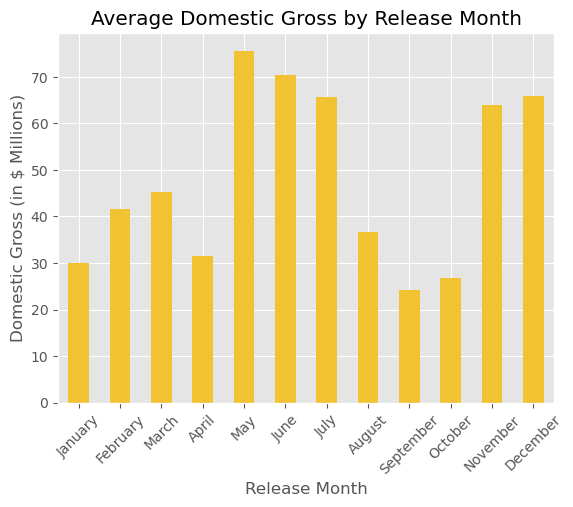

In [107]:

# Visualizing monthly data against domestic gross
ax = tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().div(1000000).sort_index(ascending=True).plot.bar(color="#f1c232")
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic Gross (in $ Millions)')
plt.xticks(rotation=45)
plt.style.use('ggplot');

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_20635/602262278.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().div(1000000).plot.bar(color="#f1c232")


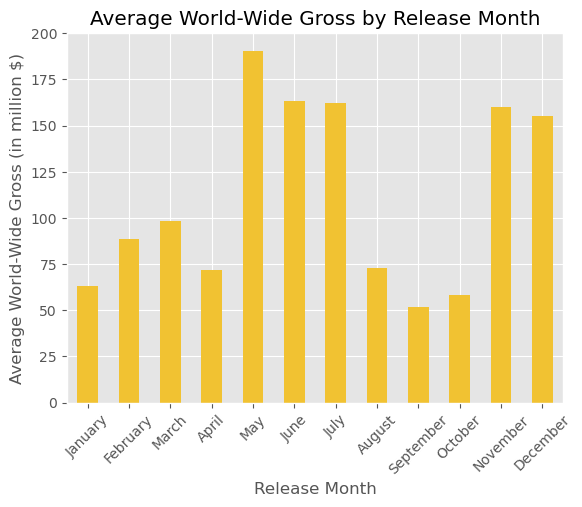

In [102]:
# Visualizing monthly data against worldwide gross
ax = tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().div(1000000).plot.bar(color="#f1c232")
plt.title('Average World-Wide Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average World-Wide Gross (in million $)')
plt.xticks(rotation=45);


In [66]:
Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', "October", 'November', 'December']

'''
def get_monthly_data(dataframe):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthly_data = {}
    
    for month in months:
        monthly_data[month] = dataframe[dataframe['release_month'] == month]['worldwide_gross']
    
    return monthly_data
'''
    

# getting monthly data
january = tn_movie_budgets[tn_movie_budgets['release_month'] == 'January']['worldwide_gross']
february = tn_movie_budgets[tn_movie_budgets['release_month'] == 'February']['worldwide_gross']
march = tn_movie_budgets[tn_movie_budgets['release_month'] == 'March']['worldwide_gross']
april = tn_movie_budgets[tn_movie_budgets['release_month'] == 'April']['worldwide_gross']
may = tn_movie_budgets[tn_movie_budgets['release_month'] == 'May']['worldwide_gross']
june = tn_movie_budgets[tn_movie_budgets['release_month'] == 'June']['worldwide_gross']
july = tn_movie_budgets[tn_movie_budgets['release_month'] == 'July']['worldwide_gross']
august = tn_movie_budgets[tn_movie_budgets['release_month'] == 'August']['worldwide_gross']
september = tn_movie_budgets[tn_movie_budgets['release_month'] == 'September']['worldwide_gross']
october = tn_movie_budgets[tn_movie_budgets['release_month'] == 'October']['worldwide_gross']
november = tn_movie_budgets[tn_movie_budgets['release_month'] == 'November']['worldwide_gross']
december = tn_movie_budgets[tn_movie_budgets['release_month'] == 'December']['worldwide_gross']

# Perform the ANOVA test
fvalue, pvalue = stats.f_oneway(january, february, march, april, may, june, july, august, september, october, november, december)

# Print the results
print("F-value:", fvalue)
print("p-value:", pvalue)


F-value: 22.89782281951194
p-value: 4.423783582271991e-46


/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_20635/747362297.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = tn_movie_budgets.groupby('release_month')['domestic_ROI'].mean().sort_index(ascending=True).plot.bar(color="#f1c232")
/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_20635/747362297.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])


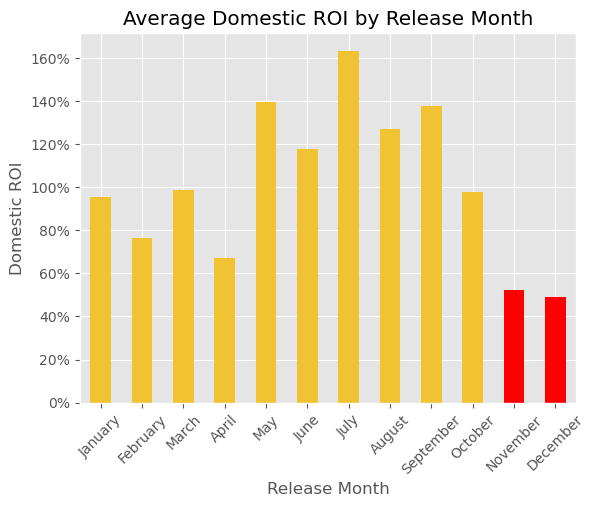

In [108]:
# Visualizing monthly data against ROI
ax = tn_movie_budgets.groupby('release_month')['domestic_ROI'].mean().sort_index(ascending=True).plot.bar(color="#f1c232")
ax.patches[10].set_facecolor('red')
ax.patches[11].set_facecolor('red')
plt.title('Average Domestic ROI by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic ROI')
plt.xticks(rotation=45)
ax.set_yticklabels(['{:.0f}%'.format(x) for x in ax.get_yticks()])
plt.style.use('ggplot');

In [68]:
# Get the data for each release month
january = tn_movie_budgets[tn_movie_budgets['release_month'] == 'January']['domestic_ROI']
february = tn_movie_budgets[tn_movie_budgets['release_month'] == 'February']['domestic_ROI']
march = tn_movie_budgets[tn_movie_budgets['release_month'] == 'March']['domestic_ROI']
april = tn_movie_budgets[tn_movie_budgets['release_month'] == 'April']['domestic_ROI']
may = tn_movie_budgets[tn_movie_budgets['release_month'] == 'May']['domestic_ROI']
june = tn_movie_budgets[tn_movie_budgets['release_month'] == 'June']['domestic_ROI']
july = tn_movie_budgets[tn_movie_budgets['release_month'] == 'July']['domestic_ROI']
august = tn_movie_budgets[tn_movie_budgets['release_month'] == 'August']['domestic_ROI']
september = tn_movie_budgets[tn_movie_budgets['release_month'] == 'September']['domestic_ROI']
october = tn_movie_budgets[tn_movie_budgets['release_month'] == 'October']['domestic_ROI']
november = tn_movie_budgets[tn_movie_budgets['release_month'] == 'November']['domestic_ROI']
december = tn_movie_budgets[tn_movie_budgets['release_month'] == 'December']['domestic_ROI']

# Perform the ANOVA test
fvalue, pvalue = stats.f_oneway(january, february, march, april, may, june, july, august, september, october, november, december)

# Print the results
print("F-value:", fvalue)
print("p-value:", pvalue)


F-value: 0.6811605829016146
p-value: 0.7577649907029964


From these graphs, there are a few main takeaways:

First, the month in which you release a film matters. We can see summer is indeed the time for blockbusters -- May through July has the highest domestic gross numbers, and some of the highest domestic ROI. We can also see a bump in gross revenue at the end of the year. This, presumably, reflects the run-up to the Oscars, when studios release some of the movies that they think are most likely to garner them prestigious awards. Notably, however, **the ROI for those same months is much lower.** This would be explained by the fact that large studios are willing to swallow losses -- that they are willing to put out rather expensive films -- in the chase for prestige and recognition. 

As a newer studio, it makes more sense to avoid this high-risk, end-of-year scramble, and to instead focus on months that seem to be a surer bet. The summer months certainly make sense; people generally have more free time and, perhaps, are looking for an air-conditioned way to spend a few hours. But it also seems that **the springtime** presents an opportunity. There is a slightly higher domestic gross in March, with a similarly higher ROI. This might reflect the fact that spring-breakers have time to spare and are therefore more likely to go to the movies. As a new studio, this could be a good period in which to break into the market.

What about the two ANOVA tests? The first one demonstrates that there is, indeed, a statistically significant difference in the gross domestic revenue of movies released in different months; the latter ANOVA is higher than our chosen $\alpha$, and thus there we cannot reject our null hypothesis. In other words, the second ANOVA shows that there is not a statistically significant difference in average ROI among the different months. Still, we can see there are variations in the means, and can try to draw conclusions accordingly.


## (4.ii) 3-D vs. 2-D Analysis

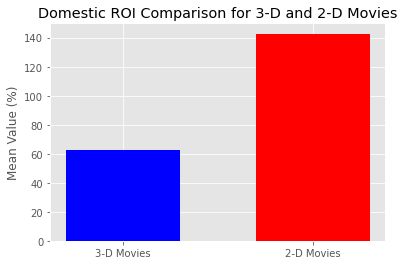

In [69]:
#Creating a Group Bar Chart Comparing the domestic ROIs

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['domestic_ROI'].mean(), no_threed_budgets_df['domestic_ROI'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Domestic ROI Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value (%)')
plt.show()

<ipython-input-70-559242532c40>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000'])
No handles with labels found to put in legend.


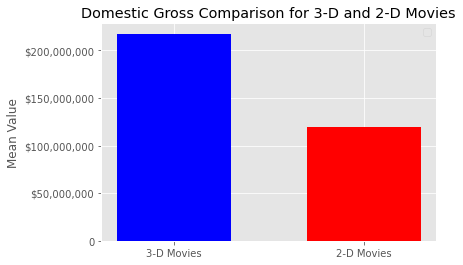

In [70]:
#Creating a Bar Chart Comparing the Domestic Gross Revenues

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['domestic_gross'].mean(), no_threed_budgets_df['domestic_gross'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Domestic Gross Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000'])
plt.legend()
plt.show()

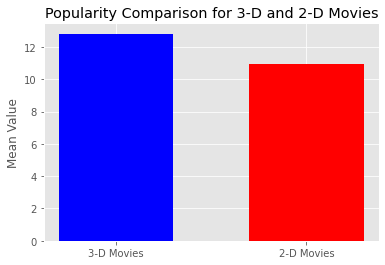

In [71]:
#Creating a Bar Chart Comparing the Popularity Metrics 

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['popularity'].mean(), no_threed_budgets_df['popularity'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Popularity Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.show()

<ipython-input-72-45a1336e0e8f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000', '$300,000,000'])
No handles with labels found to put in legend.


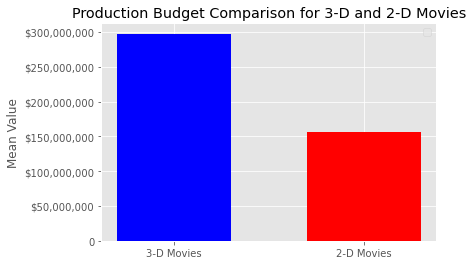

In [72]:
#Creating a Bar Chart Comparing the Production Budgets

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['production_budget'].mean(), no_threed_budgets_df['production_budget'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Production Budget Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000', '$300,000,000'])
plt.legend()
plt.show()

Conclusion: Do i need a conclusion here? Sort of explain this in the Conclusion after the 2-Sample Independent T-tests

### (4.ii.a) 2-Sample Independent T-Tests on 2-D vs. 3-D Movies

#### Using a significance level of $\alpha$ = 0.05

In [73]:
# Defining a ttest function

def ind_ttest(x, y):
    result = stats.ttest_ind(x, y, equal_var=False)
    return result

#### T-test for Domestic ROI:


Null Hypothesis:  𝐻0
 : 3-D Movies do not have different domestic ROIs than 2-D movies

Alternative Hypothesis:  𝐻𝑎
 : 3-D Movies have different domestic ROIs than 2-D movies

In [74]:
#T test for 'domestic ROI'
ind_ttest(threed_budgets_df['domestic_ROI'], no_threed_budgets_df['domestic_ROI'])

Ttest_indResult(statistic=-1.1242982270561455, pvalue=0.27786537731601707)

#### T-test for Domestic Gross:

Null Hypothesis: 𝐻0 : 3-D Movies do not have different domestic gross revenues than 2-D movies

Alternative Hypothesis: 𝐻𝑎 : 3-D Movies have different domestic gross revenues than 2-D movies

In [75]:
#T test for 'domestic gross'
ind_ttest(threed_budgets_df['domestic_gross'], no_threed_budgets_df['domestic_gross'])

Ttest_indResult(statistic=1.1658251808101647, pvalue=0.2722976009235456)

#### T-test for Popularity:

Null Hypothesis: 𝐻0 : 3-D Movies do not have different popularity values than 2-D movies

Alternative Hypothesis: 𝐻𝑎 : 3-D Movies have different popularity values than 2-D movies

In [76]:
#T test for 'popularity'
ind_ttest(threed_budgets_df['popularity'], no_threed_budgets_df['popularity'])

Ttest_indResult(statistic=0.8988202610083906, pvalue=0.3886002985217577)

### We fail to reject the null hypothesis for all three t-tests above because the p-value is less than the  𝛼 level in all three.

Conclusion: 
- 3-D movies would probably not be worth pursuing for a new studio, 
- We found no significance difference between 3-D movies and 2-D movies when comparing based on domestic ROI, domestic gross, and a popularity rating. 
-Furthermore, it is unlikely that a new studio would have a large enough budget to finance a 3-D movie, and even if it did, the fact that the 3-D movies in our sample produced a lower ROI than the 2-D movies is enough to say that it would it might not be the best option. 
-As for the popularity rating, the 3-D movies do have a slighty higher mean, but we would expect that is explained by a correlation between production budget and marketing budget, as the 3-D movies in our sample have almost double the average production budget as the 2-D movies.

## (4.iii) Experienced vs. Inexperienced Directors and Writers Analysis

### Directors Hypothesis Test

In [77]:
merged_d_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692 entries, 0 to 691
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   averagerating      692 non-null    float64       
 1   numvotes           692 non-null    int64         
 2   person_id          692 non-null    object        
 3   primary_title      692 non-null    object        
 4   Unnamed: 0         692 non-null    int64         
 5   id_x               692 non-null    int64         
 6   popularity         692 non-null    float64       
 7   release_date_x     692 non-null    object        
 8   vote_average       692 non-null    float64       
 9   vote_count         692 non-null    int64         
 10  id_y               692 non-null    int64         
 11  release_date_y     692 non-null    datetime64[ns]
 12  production_budget  692 non-null    int64         
 13  domestic_gross     692 non-null    int64         
 14  worldwide_

In [78]:
# Defining the variables for the ttests of directors

dx1 = merged_d_e['popularity']
dx2 = merged_d_e['domestic_gross']
dx3 = merged_d_e['domestic_ROI']

dy1 = merged_d_n_e['popularity']
dy2 = merged_d_n_e['domestic_gross']
dy3 = merged_d_n_e['domestic_ROI']


#### 2 Sample T-Test of Director Experience Level vs. Popularity

As you can see in the bar chart below, inexperienced directors have a lower average popularity rating compared to experienced directors. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

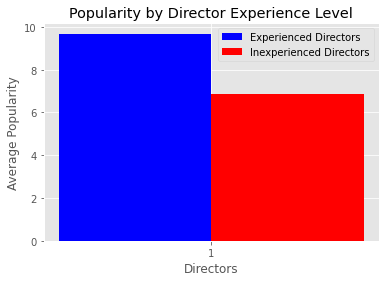

In [79]:
#Creating a Group Bar Chart Comparing the Popularity
categories = [1]
merged_d_e_means = [merged_d_e['popularity'].mean()]
merged_d_n_e_means = [merged_d_n_e['popularity'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_d_e_means, color='blue', width=bar_width, label='Experienced Directors')
plt.bar(r2, merged_d_n_e_means, color='red', width=bar_width, label='Inexperienced Directors')

# Add labels, title, and legend
plt.xlabel('Directors')
plt.ylabel('Average Popularity')
plt.title('Popularity by Director Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

Null hypothesis: experienced directors do not have a statistically significant higher popularity than inexperienced directors.

Alternative hypothesis: experienced directors have a statistically significant higher popularity than inexperienced directors.

In [80]:
# Director experience level vs. popularity
ind_ttest(dx1, dy1)

Ttest_indResult(statistic=7.651617466342026, pvalue=3.8297250116718485e-14)

Our pvalue is < our alpha of 0.05, so we can reject our null hypothesis and accept our alternative hypothesis. Movies with experienced directors may have higher popularity than movies with inexperienced directors.

#### 2 Sample T-Test of Director Experience Level vs. Domestic Gross

As you can see in the bar chart below, inexperienced directors have a lower average domestic gross compared to experienced directors. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

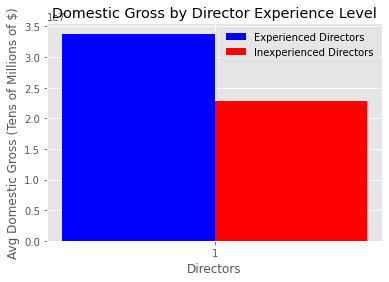

In [81]:
#Creating a Group Bar Chart Comparing the Domestic Gross
merged_d_e_means = [merged_d_e['domestic_gross'].mean()]
merged_d_n_e_means = [merged_d_n_e['domestic_gross'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_d_e_means, color='blue', width=bar_width, label='Experienced Directors')
plt.bar(r2, merged_d_n_e_means, color='red', width=bar_width, label='Inexperienced Directors')

# Add labels, title, and legend
plt.xlabel('Directors')
plt.ylabel('Avg Domestic Gross (Tens of Millions of $)')
plt.title('Domestic Gross by Director Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()


Null hypothesis: experienced directors do not have a statistically significant higher domestic gross than inexperienced directors.

Alternative hypothesis: experienced directors have a statistically significant higher domestic gross than inexperienced directors.

In [82]:
# director experience level vs. domestic_gross
ind_ttest(dx2, dy2)

Ttest_indResult(statistic=5.100966677543698, pvalue=3.888319036673861e-07)

Our pvalue is < our alpha of 0.05, so we can reject our null hypothesis and accept our alternative hypothesis. Movies with experienced directors may have higher domestic gross than movies with inexperienced directors.

#### 2 Sample T-Test of Director Experience Level vs. Domestic ROI

As you can see in the bar chart below, inexperienced directors have a lower average domestic ROI compared to experienced directors. There is about a 70% difference between the two sample means. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

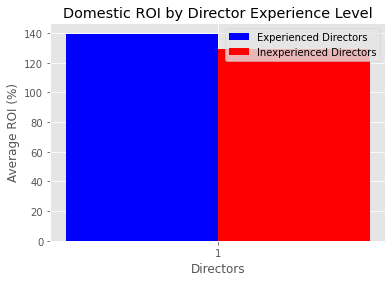

In [83]:
#Creating a Group Bar Chart Comparing the Domestic ROI
merged_d_e_means = [merged_d_e['domestic_ROI'].mean()]
merged_d_n_e_means = [merged_d_n_e['domestic_ROI'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_d_e_means, color='blue', width=bar_width, label='Experienced Directors')
plt.bar(r2, merged_d_n_e_means, color='red', width=bar_width, label='Inexperienced Directors')

# Add labels, title, and legend
plt.xlabel('Directors')
plt.ylabel('Average ROI (%)')
plt.title('Domestic ROI by Director Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

Null hypothesis: experienced directors do not have a statistically significant higher domestic ROI than inexperienced directors.

Alternative hypothesis: experienced directors have a statistically significant higher domestic ROI than inexperienced directors.

In [84]:
# director experience level vs. domestic_ROI
ind_ttest(dx3, dy3)

Ttest_indResult(statistic=0.1977708070948829, pvalue=0.8432682473676519)

Our pvalue is > our alpha of 0.05, so we *fail* to reject our null hypothesis. Movies with experienced directors may experience no difference in domestic gross compared with movies with inexperienced directors.

Conclusion: Hiring experienced directors may lead to more popular and higher grossing movies, but does not lead to higher domestic ROI relative to less experienced directors. Since less experienced directors are also likely to be more inexpensive to hire, we recommend choosing a director based on their salary expectations rather than the number of movies they have led. 

### Writers Hypothesis Test

In [85]:
# defining the variables for the ttest of writers

wx1 = merged_w_e['popularity']
wx2 = merged_w_e['domestic_gross']
wx3 = merged_w_e['domestic_ROI']

wy1 = merged_w_n_e['popularity']
wy2 = merged_w_n_e['domestic_gross']
wy3 = merged_w_n_e['domestic_ROI']


#### 2 Sample T-Test of Writer Experience Level vs. Popularity

As you can see in the bar chart below, inexperienced writers have a lower average popularity rating compared to experienced writers. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

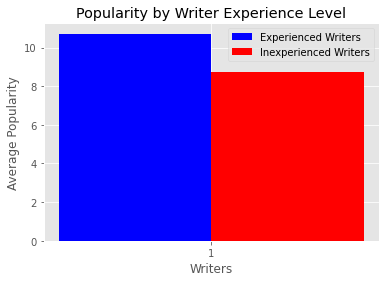

In [86]:
#Creating a Group Bar Chart Comparing the Popularity
merged_w_e_means = [merged_w_e['popularity'].mean()]
merged_w_n_e_means = [merged_w_n_e['popularity'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_w_e_means, color='blue', width=bar_width, label='Experienced Writers')
plt.bar(r2, merged_w_n_e_means, color='red', width=bar_width, label='Inexperienced Writers')

# Add labels, title, and legend
plt.xlabel('Writers')
plt.ylabel('Average Popularity')
plt.title('Popularity by Writer Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

Null hypothesis: experienced writers do not have a statistically significant higher popularity rating than inexperienced writers.

Alternative hypothesis: experienced writers have a statistically significant higher popularity rating than inexperienced writers.

In [87]:
# writer experience level vs. popularity
ind_ttest(wx1, wy1)

Ttest_indResult(statistic=6.2228713778481906, pvalue=7.229262840829084e-10)

Our pvalue is < our alpha of 0.05, so we can reject our null hypothesis and accept our alternative hypothesis. Movies with experienced writers may be more popular than movies with inexperienced writers.

#### 2 Sample T-Test of Writer Experience Level vs. Domestic Gross

As you can see in the bar chart below, inexperienced writers have a lower average domestic gross compared to experienced writers. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

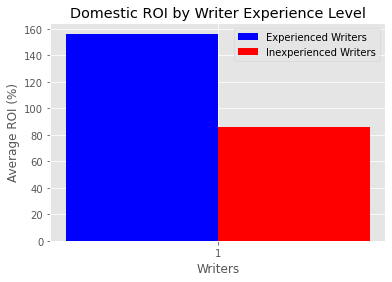

In [88]:
#Creating a Group Bar Chart Comparing the Domestic ROI
merged_w_e_means = [merged_w_e['domestic_ROI'].mean()]
merged_w_n_e_means = [merged_w_n_e['domestic_ROI'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_w_e_means, color='blue', width=bar_width, label='Experienced Writers')
plt.bar(r2, merged_w_n_e_means, color='red', width=bar_width, label='Inexperienced Writers')

# Add labels, title, and legend
plt.xlabel('Writers')
plt.ylabel('Average ROI (%)')
plt.title('Domestic ROI by Writer Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

Null hypothesis: experienced writers do not have a statistically significant higher domestic gross than inexperienced writers.

Alternative hypothesis: experienced writers have a statistically significant higher domestic gross than inexperienced writers.

In [89]:
# writer experience level vs. domestic_gross
ind_ttest(wx3, wy3)

Ttest_indResult(statistic=1.3224467079031759, pvalue=0.18648605766547535)

Our pvalue is > our alpha of 0.05, so we fail to reject our null hypothesis. Movies with experienced writers do not lead to a higher domestic gross than movies with inexperienced writers.

#### 2 Sample T-Test of Writer Experience Level vs. Domestic ROI

As you can see in the bar chart below, inexperienced writers have a lower average domestic ROI compared to experienced writers. We would like to test if the means of these two samples are statistically significant, so we will perform a 2-sample t-test. 

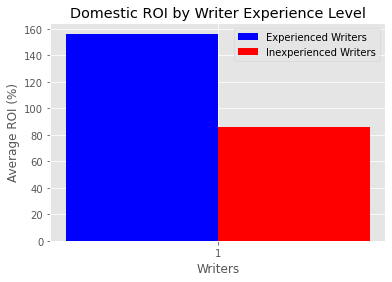

In [90]:
#Creating a Group Bar Chart Comparing the Domestic ROI
merged_w_e_means = [merged_w_e['domestic_ROI'].mean()]
merged_w_n_e_means = [merged_w_n_e['domestic_ROI'].mean()]

bar_width = 0.25
# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, merged_w_e_means, color='blue', width=bar_width, label='Experienced Writers')
plt.bar(r2, merged_w_n_e_means, color='red', width=bar_width, label='Inexperienced Writers')

# Add labels, title, and legend
plt.xlabel('Writers')
plt.ylabel('Average ROI (%)')
plt.title('Domestic ROI by Writer Experience Level')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

Null hypothesis: experienced writers do not have a statistically significant higher domestic ROI than inexperienced writers.

Alternative hypothesis: experienced writers have a statistically significant higher domestic ROI than inexperienced writers.

In [91]:
# writer experience level vs. domestic_ROI
ind_ttest(wx3, wy3)

Ttest_indResult(statistic=1.3224467079031759, pvalue=0.18648605766547535)

Our pvalue is > our alpha of 0.05, so we *fail* to reject our null hypothesis. Movies with experienced writers may experience no difference in domestic gross compared with movies with inexperienced writers.

Conclusion: Hiring experienced writers may lead to more popular movies, but does not lead to higher domestic gross or higher domestic ROI relative to less experienced writers. Since less experienced writers are also likely to be more inexpensive to hire, we recommend choosing a writer based on their salary expectations rather than the number of movies they have led. 

## (4.iv) Runtime and Budget Analysis

In [107]:
# defining the variables for runtime and budget tests

rx = sm.add_constant(movie_basics_budget['runtime_minutes'])
bx = sm.add_constant(movie_basics_budget['production_budget'])

y1 = movie_basics_budget['popularity']
y2 = movie_basics_budget['domestic_gross']
y3 = movie_basics_budget['domestic_ROI']


In [108]:
# Defining a linear regression function

def lin_reg(y, x):
    lin_reg_model = sm.OLS(y, x).fit().summary()
    return lin_reg_model

### Budget Regressions and Visuals

#### Budget vs. Popularity Regression
In the scatter plot below, there seems to be a generally positive relationship between production budget and a movie's popularity. We would like to test the strength of this apparent linear relationship using a simple linear regression.

In the resulting regression tables, the coefficient on production_budget represents the change in each dependent variable as a result of a change in production_budget.

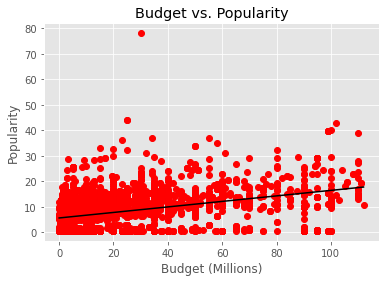

In [109]:
# budget vs. popularity scatter
best_line((bx['production_budget']/1000000), y1, 'Budget vs. Popularity', 'Budget (Millions)', 'Popularity')

In [110]:
# budget vs. popularity
lin_reg(y1, bx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     592.9
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          5.48e-120
Time:                        18:48:37   Log-Likelihood:                -10104.
No. Observations:                3101   AIC:                         2.021e+04
Df Residuals:                    3099   BIC:                         2.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.6831      0.155     36.560      0.000       5.378       5.988
production_budget  1.082e-07   4.44e-09     24.350      0.000    9.95e-08    1.17e-07
==============================================================================
Omnibus:                      823.847   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5603.464
Skew:                           1.084   Prob(JB):                         0.00
Kurtosis:                       9.218   Cond. No.                     4.81e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our p value from this regression is smaller than our alpha value of 0.05, which means that the coefficient on our indpendent variable (production budget) is statistically significant. However, that coefficient is near zero. Further, the R squared value from this table is also small. Its value asserts that only about 16% of variance in popularity can be explained by production budget. 

#### Budget vs. Domestic Gross Regression
In the scatter plot below, there seems to be a generally positive relationship between production budget and a movie's domestic gross. We would like to test the strength of this apparent linear relationship using a simple linear regression.

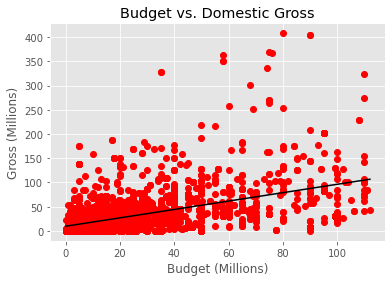

In [111]:
# budget vs. domestic gross scatter
best_line((bx['production_budget']/1000000), (y2/1000000), 'Budget vs. Domestic Gross', 'Budget (Millions)', 'Gross (Millions)')


In [112]:
# budget vs. domestic gross
lin_reg(y2, bx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     1012.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          2.16e-192
Time:                        18:48:55   Log-Likelihood:                -58570.
No. Observations:                3101   AIC:                         1.171e+05
Df Residuals:                    3099   BIC:                         1.172e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.626e+06   9.53e+05     10.098      0.000    7.76e+06    1.15e+07
production_budget     0.8667      0.027     31.808      0.000       0.813       0.920
==============================================================================
Omnibus:                     2070.184   Durbin-Watson:                   0.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36212.330
Skew:                           2.933   Prob(JB):                         0.00
Kurtosis:                      18.680   Cond. No.                     4.81e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In this regression our p value is less than our alpha value of 0.05, which means our coefficient is statistically significant. However, our R squared is fairly small. It implies that about 25% of variation in domestic ROI can be explained by production budget.

Although our three dependent variables of choice are popularity, domestic gross, and domestic ROI, we do not run a regression of production budget on ROI. This is because the formula for ROI contains production budget in both the numerator and denominator. As a result, a regression between the two would result in an artificially high/strong linear relationship. 

Conclusion: A higher production budget does seem to lead to a higher domestic gross, but only slightly. Therefore, we can recommend that our client spend "reasonably." Obviously, this budgetting decision is subjective, but the ultimate message here is that excessive spending is not necessary to create profit.

Note: In preliminary analyses not recorded in this final notebook, we ran regressions of budget on domestic gross *including* budgetary outliers (movies that have huge budgets, in the hundreds of millions). In those cases, the R squared for budget and domesic gross jumps to 60%. 

However, that large a budget is simply unrealistic for a new movie studio. On top of that, movies that command that much money likely also have huge marketing budgets, famous actors, extensive media attention, studios with strong influence, etc. All these are confounding factors for our regression as well as unrealistic business maneuvers for our client's profile. That is why we have run our budgetary regressions *excluding* outliers.

### Runtime Regressions and Visuals

#### Runtime vs. Popularity Regression
In the scatter plot below, there seems to be a generally positive relationship between runtime and a movie's popularity. We would like to test the strength of this apparent linear relationship using a simple linear regression.

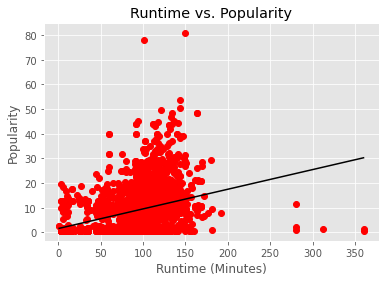

In [98]:
# runtime vs. popularity scatter
best_line(rx['runtime_minutes'], y1, 'Runtime vs. Popularity', 'Runtime (Minutes)', 'Popularity')

In [99]:
# runtime vs. popularity regression
lin_reg(y1, rx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     309.2
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           3.74e-66
Time:                        18:27:53   Log-Likelihood:                -11194.
No. Observations:                3213   AIC:                         2.239e+04
Df Residuals:                    3211   BIC:                         2.240e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.5653      0.458      3.416      0.001       0.667       2.464
runtime_minutes     0.0797      0.005     17.584      0.000       0.071       0.089
==============================================================================
Omnibus:                     1077.315   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5672.743
Skew:                           1.507   Prob(JB):                         0.00
Kurtosis:                       8.770   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the p value in this regression is less than our alpha of 0.05, the coefficient on our independent variable (runtime) is very small, and the R squared value is near zero. This means runtime explains almost no variance in popularity.

#### Runtime vs. Domestic Gross Regression
In the scatter plot below, there seems to be a generally positive relationship between runtime and a movie's domestic gross. We would like to test the strength of this apparent linear relationship using a simple linear regression.

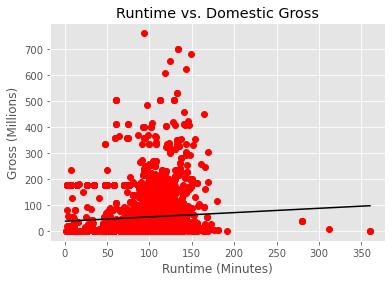

In [100]:
# runtime vs. domestic gross scatter
best_line(rx['runtime_minutes'], (y2/1000000), 'Runtime vs. Domestic Gross', 'Runtime (Minutes)', 'Gross (Millions)')

In [101]:
# runtime vs. domestic gross regression
lin_reg(y2, rx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.99
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000542
Time:                        18:27:53   Log-Likelihood:                -63154.
No. Observations:                3213   AIC:                         1.263e+05
Df Residuals:                    3211   BIC:                         1.263e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.734e+07   4.83e+06      7.726      0.000    2.79e+07    4.68e+07
runtime_minutes  1.656e+05   4.78e+04      3.463      0.001    7.18e+04    2.59e+05
==============================================================================
Omnibus:                     2090.613   Durbin-Watson:                   0.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24989.075
Skew:                           2.991   Prob(JB):                         0.00
Kurtosis:                      15.283   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the p value of the regression is smaller than our alpha, and the coefficient is very large, the R squared value is near zero. This means that runtime explains almost none of the variance in domestic gross. 

#### Runtime vs. Domestic ROI Regression
In the scatter plot below, there seems to be a generally positive relationship between runtime and a movie's domestic ROI. We would like to test the strength of this apparent linear relationship using a simple linear regression.

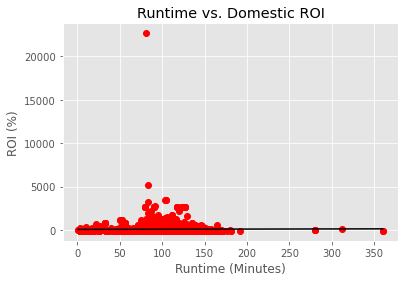

In [102]:
# runtime vs. domestic roi scatter
best_line(rx['runtime_minutes'], y3, 'Runtime vs. Domestic ROI', 'Runtime (Minutes)', 'ROI (%)')

In [103]:
# runtime vs. domestic ROI regression
lin_reg(y3, rx)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           domestic_ROI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2891
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.591
Time:                        18:27:53   Log-Likelihood:                -24768.
No. Observations:                3213   AIC:                         4.954e+04
Df Residuals:                    3211   BIC:                         4.955e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              78.4890     31.317      2.506      0.012      17.085     139.893
runtime_minutes     0.1666      0.310      0.538      0.591      -0.441       0.774
==============================================================================
Omnibus:                     7773.061   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        124307720.724
Skew:                          24.454   Prob(JB):                         0.00
Kurtosis:                     965.364   Cond. No.                         333.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p value of this regression is 0.59, much larger than our alpha value of 0.05. Therefore, the coefficient on runtime is not statistically significant. In addition, the R squared value is 0, which means runtime does not explain any variance in domestic ROI. 

Conclusion: Runtime of a movie seems to have no linear relationship with any of our dependent variables of concern. As such, our recommendation to our client is to not focus on the length of the feature. Produce a film which generally falls within the normal length audiences expect, because producing any longer or shorter doesn't improve movie outcomes. 

All this being said, it is possible that runtime has a *non-linear* relationship with our dependent variables. Such a regression is not within the scope of this project.

# Conclusion

Our goal has been to provide data-backed recommendations on the best strategy for our client to enter the movie industry. Using three extensive datasets and multiple statistical models, we provide the five recommendations below, each tailored to the resources and interests of a new firm. 

## Summation of Recommendations 

Release Month Recommendation:
    
3-D vs. 2-D Movies

Experienced Directors and Writers: The experience level of directors and writers does not have a statistically significant effect on domestic ROI. Since experienced directors and writers are more expensive to hire, we recommend that movie studios hire based on salary expectations rather than length of resume. This will keep costs down without sacrificing monetary gain.

Budget Recommendation: Budget explains about 58% of variance in domestic gross, which means that spending more on a movie is generally a good investment. However, we recognize that our firm may not have as many funds compared to established movie studios. Therefore, we recommend that our firm maximize production value *within* their capabilities.

Runtime Recommendation: Runtime has little to no effect on monetary outcomes or movie popularity. When producing a film, our client should focus on remaining within the average/normal length that a viewer expects.

## Limitations

## Next Steps